In [6]:
import copy
import pickle as pk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [7]:
df_seq_hit = pd.read_csv("orthologs-fly-2-human.tsv", sep="\t", header=0)
df_seq_hit["FlybaseId-Fly"] = "7227." + df_seq_hit["FlybaseId-Fly"]
df_seq_hit["EnsemblPeptide-Human"] = "9606." + df_seq_hit["EnsemblPeptide-Human"]

In [8]:
df_seq_hit

,ExternalName-Fly,FlybaseId-Fly,EnsemblPeptide-Human,ExternalName-Human
0,mt:ND5,7227.FBpp0390633,9606.ENSP00000354813,MT-ND5
1,mt:ND2,7227.FBpp0100175,9606.ENSP00000355046,MT-ND2
2,mt:CoIII,7227.FBpp0100180,9606.ENSP00000354982,MT-CO3
3,mt:ATPase6,7227.FBpp0390630,9606.ENSP00000354632,MT-ATP6
4,mt:ND4,7227.FBpp0390632,9606.ENSP00000354961,MT-ND4
...,...,...,...,...
334001,Cyp4d21,7227.FBpp0079095,NaN,CYP4A22
334002,Cyp4d21,7227.FBpp0079095,9606.ENSP00000360958,CYP4A22
334003,Cyp4d21,7227.FBpp0079095,9606.ENSP00000360957,CYP4A22
334004,Cyp4d21,7227.FBpp0079095,9606.ENSP00000482952,CYP4A22


In [9]:
def lexical_pair(x, y):
    if x < y:
        return (x, y)
    else:
        return (y, x)

In [10]:
pair_directory = (
    "/afs/csail.mit.edu/u/s/samsl/Work/TT3D/FoldSeek_BriefCommunication/data/pairs"
)
human_training = pd.read_csv(f"{pair_directory}/human_train.tsv", sep="\t", header=None)
fly_test = pd.read_csv(f"{pair_directory}/fly_test.tsv", sep="\t", header=None)
ecoli_test = pd.read_csv(f"{pair_directory}/yeast_test.tsv", sep="\t", header=None)

human_edge_lookup = {}
for _, r in tqdm(human_training.iterrows(), total=len(human_training)):
    human_edge_lookup[lexical_pair(r[0], r[1])] = r[2]

  0%|          | 0/421792 [00:00<?, ?it/s]

In [37]:
human_pos = human_training[human_training[2] == 1]

In [38]:
human_proteins = set(human_training[0]).union(human_training[1])

In [39]:
human_to_fly_lookup = {}
for hp in tqdm(list(human_proteins)):
    human_to_fly_lookup[hp] = df_seq_hit[df_seq_hit["EnsemblPeptide-Human"] == hp][
        "FlybaseId-Fly"
    ].values

  0%|          | 0/15816 [00:00<?, ?it/s]

In [40]:
# df_struct_hit = pd.read_csv("fly_against_human_foldseek_mmseqs.tsv", sep = "\t", header = None)
df_struct_hit = pd.read_csv(
    "structure_homology/fly_against_human_foldseek_mmseqs.tsv",
    sep="\t",
    header=None,
)
thresh = 1e-10
df_struct_thresh = df_struct_hit[df_struct_hit[10] < thresh]

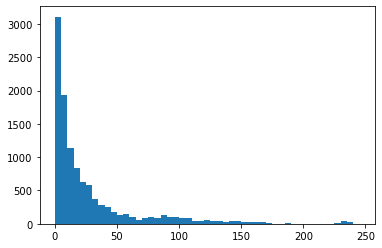

In [41]:
plt.hist(df_struct_thresh[1].value_counts().values, bins=np.arange(0, 250, 5))
plt.show()

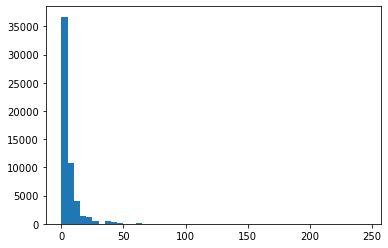

In [42]:
plt.hist(
    df_seq_hit["EnsemblPeptide-Human"].value_counts().values,
    bins=np.arange(0, 250, 5),
)
plt.show()

In [43]:
fly_struct_lookup = {}
for hp in tqdm(list(human_proteins)):
    fly_struct_lookup[hp] = df_struct_thresh[df_struct_thresh[1] == hp][0].values

  0%|          | 0/15816 [00:00<?, ?it/s]

In [44]:
# import pickle as pk

# with open("sequence_human_to_fly_map.pk","wb") as f:
#     pk.dump(human_to_fly_lookup, f)

# with open("structure_human_to_fly_map.pk","wb") as f:
#     pk.dump(fly_struct_lookup, f)

In [45]:
with open("sequence_human_to_fly_map.pk", "rb") as f:
    human_to_fly_lookup = pk.load(f)

with open("structure_human_to_fly_map.pk", "rb") as f:
    fly_struct_lookup = pk.load(f)

In [46]:
from itertools import product

fly_expanded = []

for _, r in tqdm(human_pos.iterrows(), total=len(human_pos)):
    p1 = r[0]
    p2 = r[1]
    p1_hits = human_to_fly_lookup[p1]
    p2_hits = human_to_fly_lookup[p2]
    for f1, f2 in product(p1_hits, p2_hits):
        fly_expanded.append(lexical_pair(f1, f2))
fly_expanded = pd.DataFrame(fly_expanded)

  0%|          | 0/38344 [00:00<?, ?it/s]

In [47]:
from itertools import product

fly_expanded_struct = []

for _, r in tqdm(human_pos.iterrows(), total=len(human_pos)):
    p1 = r[0]
    p2 = r[1]
    p1_hits = fly_struct_lookup[p1]
    p2_hits = fly_struct_lookup[p2]
    for f1, f2 in product(p1_hits, p2_hits):
        fly_expanded_struct.append(lexical_pair(f1, f2))
fly_expanded_struct = pd.DataFrame(fly_expanded_struct)

  0%|          | 0/38344 [00:00<?, ?it/s]

In [48]:
fly_expanded_dd = fly_expanded.drop_duplicates()
fly_expanded_struct_dd = fly_expanded_struct.drop_duplicates()

In [49]:
len(fly_expanded_dd)

177376

In [50]:
len(fly_expanded_struct_dd)

3150457

In [51]:
def lexical_fix(
    df,
    ncol1="protein1",
    ncol2="protein2",
    rest_cols=["sequence1", "sequence2"],
):
    newdf = []
    for _, r in tqdm(df.iterrows(), total=len(df)):
        p1 = r[ncol1]
        p2 = r[ncol2]
        rest = r[rest_cols]
        pair = lexical_pair(p1, p2)
        newdf.append([*pair, *rest])
    df = pd.DataFrame(newdf)
    df.columns = [ncol1, ncol2, *rest_cols]
    return df

In [52]:
full_true_fly_net = pd.read_csv("fly_full_27k.tsv", sep="\t", header=0)
tt3d_full_fly_net = pd.read_csv("full_fly_tt3d_out.tsv", sep="\t", header=None)

In [53]:
full_true_fly_net = lexical_fix(full_true_fly_net)

  0%|          | 0/27470 [00:00<?, ?it/s]

In [54]:
full_true_fly_net = full_true_fly_net[["protein1", "protein2"]]
full_true_fly_net.columns = [0, 1]

In [55]:
import pandas as pd

In [56]:
import h5py

fly_embeddings = h5py.File(
    "/afs/csail/u/s/samsl/Work/databases/STRING/d.mela/fly.h5", "r"
)
fly_emb_keys = list(fly_embeddings.keys())

In [57]:
def filter_df(df, keys):
    return df[df[0].isin(keys) & df[1].isin(keys)]

In [58]:
sequence_f0_fstar = filter_df(
    pd.concat([fly_expanded_dd, full_true_fly_net]).drop_duplicates(),
    fly_emb_keys,
)
struct_f0_fstar = filter_df(
    pd.concat([fly_expanded_struct_dd, full_true_fly_net]).drop_duplicates(),
    fly_emb_keys,
)

In [59]:
sequence_f0_fstar = pd.read_csv("sequence_f0_fstar.tsv", sep="\t", header=None)
struct_f0_fstar = pd.read_csv("structure_f0_fstar.tsv", sep="\t", header=None)

In [60]:
sequence_f0_fstar = filter_df(sequence_f0_fstar, fly_emb_keys)
struct_f0_fstar = filter_df(struct_f0_fstar, fly_emb_keys)

In [61]:
len(sequence_f0_fstar)

110249

In [62]:
len(struct_f0_fstar)

3160204

In [63]:
# sequence_f0_fstar.to_csv("sequence_f0_fstar.tsv",sep="\t",header=None,index=False)
# struct_f0_fstar.to_csv("structure_f0_fstar.tsv",sep="\t",header=None,index=False)

In [64]:
fstar = full_true_fly_net
seq_f0 = fly_expanded_dd
struct_f0 = fly_expanded_struct_dd

In [65]:
seq_tp = pd.merge(fstar, seq_f0, how="inner").shape[0]
seq_precision = seq_tp / len(seq_f0)
seq_recall = seq_tp / len(fstar)
print(seq_precision, seq_recall)

0.05974878224788021 0.385802693847834


In [66]:
struct_tp = pd.merge(fstar, struct_f0, how="inner").shape[0]
struct_precision = struct_tp / len(struct_f0)
struct_recall = struct_tp / len(fstar)
print(struct_precision, struct_recall)

0.005625533057584979 0.6451765562431744


In [67]:
tt3d_sequence_f0_fstar_all = pd.read_csv(
    "~/Work/TT3D/FoldSeek_BriefCommunication/sequence_f0_fstar_out.tsv",
    sep="\t",
    header=None,
)
tt3d_structure_f0_fstar_all = pd.read_csv(
    "~/Work/TT3D/FoldSeek_BriefCommunication/structure_f0_fstar_out.tsv",
    sep="\t",
    header=None,
)

In [68]:
fstar_labeled = copy.deepcopy(fstar)
fstar_labeled[2] = 1

In [69]:
from sklearn.metrics import average_precision_score, precision_recall_curve

aupr: 0.2811500396643538


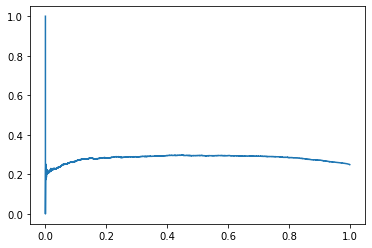

In [70]:
seq_merged_df = pd.merge(
    tt3d_sequence_f0_fstar_all,
    fstar_labeled,
    left_on=[0, 1],
    right_on=[0, 1],
    how="outer",
).fillna(0)
print(f"aupr: {average_precision_score(seq_merged_df['2_y'], seq_merged_df['2_x'])}")
pr, re, th = precision_recall_curve(seq_merged_df["2_y"], seq_merged_df["2_x"])
plt.plot(re, pr)
plt.show()

In [71]:
pr[np.argwhere(re > 0.3858)], re[np.argwhere(re > 0.3858)]

(array([[0.24916326],
        [0.24933509],
        [0.24977263],
        ...,
        [0.29332964],
        [0.29333776],
        [0.293354  ]]),
 array([[1.        ],
        [0.99992719],
        [0.99974518],
        ...,
        [0.38580269],
        [0.38580269],
        [0.38580269]]))

In [72]:
len(fstar) / len(tt3d_structure_f0_fstar_all)

0.008692476814787907

aupr: 0.07590007147674763


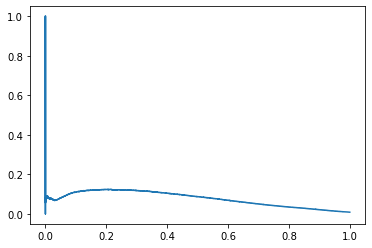

In [73]:
struct_merged_df = pd.merge(
    tt3d_structure_f0_fstar_all,
    fstar_labeled,
    left_on=[0, 1],
    right_on=[0, 1],
    how="outer",
).fillna(0)
print(
    f"aupr: {average_precision_score(struct_merged_df['2_y'], struct_merged_df['2_x'])}"
)
pr, re, th = precision_recall_curve(struct_merged_df["2_y"], struct_merged_df["2_x"])
plt.plot(re, pr)
plt.show()

In [74]:
pr[np.argwhere(re > 0.6452)], re[np.argwhere(re > 0.6452)]

(array([[0.00869248],
        [0.00869264],
        [0.00869732],
        ...,
        [0.06035346],
        [0.06035366],
        [0.06035387]]),
 array([[1.        ],
        [1.        ],
        [0.99992719],
        ...,
        [0.64521296],
        [0.64521296],
        [0.64521296]]))